## Forecast validation for Euclid cosmological probes: Fisher Matrix
Student: Antonia Cisternas \
Teacher: Domenico Sapone

In [526]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy import stats, interpolate
import sympy
from scipy.integrate import cumtrapz, solve_ivp, odeint, quadrature, dblquad
import autograd.numpy as np
from autograd import grad


### Fiducial parameters

We obtain the number density in each redshift bin:
$$
n(z) = \frac{dN(z)}{d\Omega dz} \frac{A_{survey}}{V_s(z)} \Delta z
$$

In [527]:
# f and D for each z_mean:
#f = [0.8790616234808487, 0.9052940279841754, 0.9248305916607235, 0.942646864519483]
#D = [0.6051299241324081, 0.5557769195555776, 0.5132266632166314, 0.46785418122063316]

# Based on table 3 of the page 14:

# We define n using data of number of galaxies per unit area and redshift intervals.
# n = [6.86 * 10**(-4), 5.58 * 10**(-4), 4.21* 10**(-4), 2.61 * 10**(-4)]
V_s = [7.94 * 10**(9), 9.15* 10**(9), 10.05* 10**(9), 16.22* 10**(9)] 
#galazy bias factor
b = [1.4614804, 1.6060949, 1.7464790, 1.8988660]

# Centered position of each bin
z_i = [1., 1.2, 1.4, 1.65]
z_min = [0.9, 1.1, 1.3, 1.5]
z_max = [1.1, 1.3, 1.5, 1.8]

In [528]:
#Fiducial parameters
wb = 0.022445
wm = 0.143648
h = 0.67
c = 300.000

Om_b0 = wb/ (h**2)
H0 = 100 * h
Om_m0 = wm/ (h**2)
ns = 0.96 # Spectral index of the primordial density power spectrum
Om_DE0 = 0.68

m_nu = 0.06
w_0 = -1
w_a = 0

gamma = 0.55

s8_reference= 0.815583

A_surv = 15000 # Survey area
s_z = 0.0001 # Spectroscopic redshift error
P_s = 0 # Shot noise

# Densidad por unidad de área: dN/(dOmega dz)
dn3= [1815.0, 1701.5, 1410.0, 940.97]

n = np.zeros_like(z_i)
for i in range(len(z_i)):
    n[i] = dn3[i] * A_surv * (z_max[i] - z_min[i])/ V_s[i]

print('n:', n)


n: [0.00068577 0.00055787 0.0004209  0.00026106]


### Obtaining the data and interpolation 
Archives "Pk-fiducial-z_0_.dat" and "Pknw-fiducial-z_0_.dat" \
Columns: $k$ , $Pk/ s_8^2$ ,  $s_8$

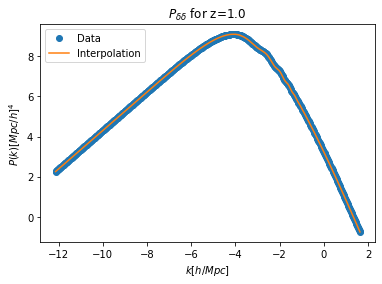

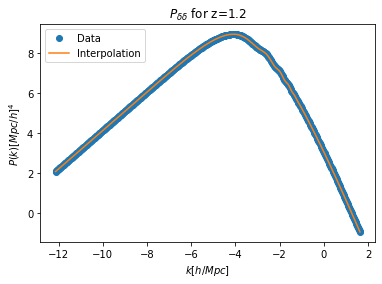

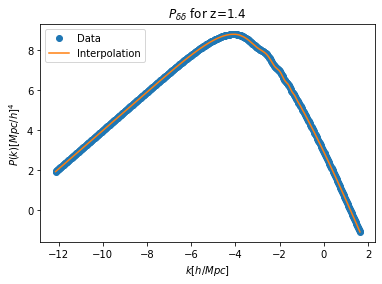

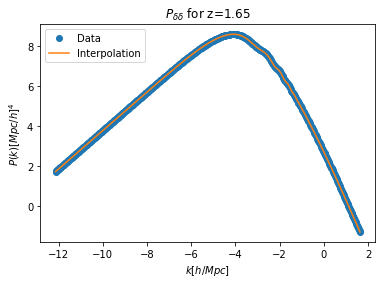

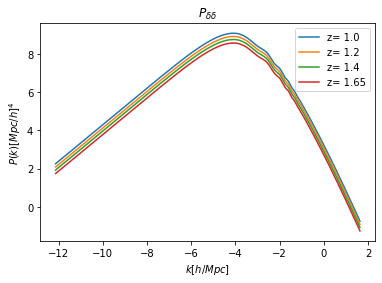

In [529]:
Pk_00 = np.loadtxt("Pk-fiducial\Pk-fiducial-z_00.dat")
Pk_01 = np.loadtxt("Pk-fiducial\Pk-fiducial-z_01.dat")
Pk_02 = np.loadtxt("Pk-fiducial\Pk-fiducial-z_02.dat")
Pk_03 = np.loadtxt("Pk-fiducial\Pk-fiducial-z_03.dat")

Pk_ = [Pk_00,Pk_01, Pk_02, Pk_03 ]

# Cubic spline interpolation
k_= np.empty(4, dtype=object)
y_= np.empty(4, dtype=object)
P_dd_ = np.empty(4, dtype=object)
k_new= np.empty(4, dtype=object)
y_new= np.empty(4, dtype=object)

# i recorre los redshifts
for i in range(0,4):
    k_[i] = np.log(Pk_[i][:,0])
    y_[i] = np.log(Pk_[i][:,1] * (Pk_[i][:,2]**2))
    P_dd_[i] = interpolate.interp1d(k_[i], y_[i], kind='cubic')
    k_new[i] = np.log(np.arange(Pk_[i][:,0][0], Pk_[i][:,0][-1], 0.0001))
    y_new[i] = P_dd_[i](k_new[i])
    plt.title(r"$P_{\delta \delta}$ for z=" + f"{z_i[i]}")
    plt.plot(k_[i], y_[i], 'o', label= "Data")
    plt.plot(k_new[i], y_new[i], '-', label= "Interpolation")
    plt.xlabel(r"$k[h/Mpc]$")
    plt.ylabel(r"$P(k)[Mpc/h]^4$")
    plt.legend()
    plt.show()

plt.title(r"$P_{\delta \delta}$")
plt.plot(k_new[0], y_new[0], '-', label= f"z= {z_i[0]}")
plt.plot(k_new[1], y_new[1], '-', label= f"z= {z_i[1]}")
plt.plot(k_new[2], y_new[2], '-', label= f"z= {z_i[2]}")
plt.plot(k_new[3], y_new[3], '-', label= f"z= {z_i[3]}")
plt.xlabel(r"$k[h/Mpc]$")
plt.ylabel(r"$P(k)[Mpc/h]^4$")
plt.legend()
plt.show()


def P_dd(k, zi):
    i = z_i.index(zi)
    return P_dd_[i](k)

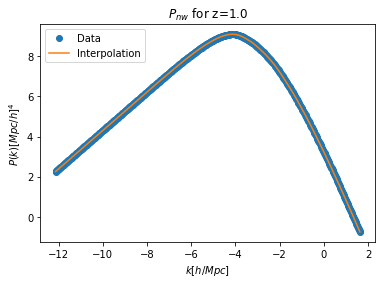

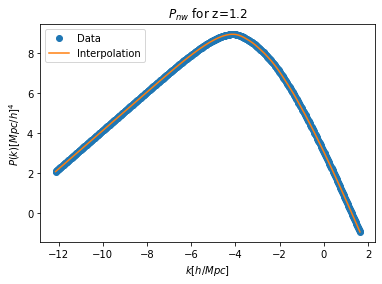

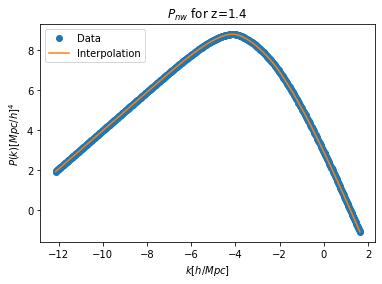

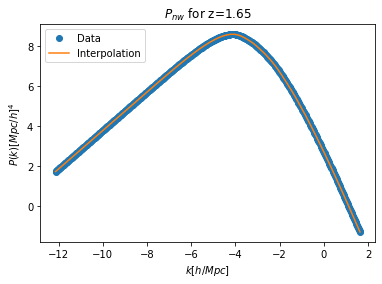

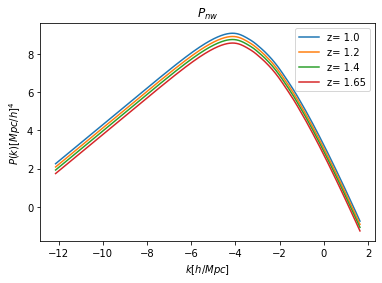

In [530]:
# For Pk_nw (no wiggled power spectrum)
Pk_nw_00 = np.loadtxt("Pk-nw-fiducial\Pk-nw-fiducial-z_00.dat")
Pk_nw_01 = np.loadtxt("Pk-nw-fiducial\Pk-nw-fiducial-z_01.dat")
Pk_nw_02 = np.loadtxt("Pk-nw-fiducial\Pk-nw-fiducial-z_02.dat")
Pk_nw_03 = np.loadtxt("Pk-nw-fiducial\Pk-nw-fiducial-z_03.dat")

Pk_nw = [Pk_nw_00,Pk_nw_01, Pk_nw_02, Pk_nw_03 ]

# Cubic spline interpolation
k_nw= np.empty(4, dtype=object)
y_nw= np.empty(4, dtype=object)
P_nw_ = np.empty(4, dtype=object)
k_nw_new= np.empty(4, dtype=object)
y_nw_new= np.empty(4, dtype=object)
# i recorren los redshifts
for i in range(0,4):
    k_nw[i] = np.log(Pk_nw[i][:,0])
    y_nw[i] = np.log(Pk_nw[i][:,1] * (Pk_nw[i][:,2]**2))
    P_nw_[i] = interpolate.interp1d(k_nw[i], y_nw[i], kind='cubic')
    k_nw_new[i] = np.log(np.arange(Pk_nw[i][:,0][0], Pk_nw[i][:,0][-1], 0.0001))
    y_nw_new[i] = P_nw_[i](k_nw_new[i])
    plt.title(r"$P_{nw}$ for z=" + f"{z_i[i]}")
    plt.plot(k_nw[i], y_nw[i], 'o', label= "Data")
    plt.plot(k_nw_new[i], y_nw_new[i], '-', label= "Interpolation")
    plt.xlabel(r"$k[h/Mpc]$")
    plt.ylabel(r"$P(k)[Mpc/h]^4$")
    plt.legend()
    plt.show()

plt.title(r"$P_{nw}$")
plt.plot(k_nw_new[0], y_nw_new[0], '-', label= f"z= {z_i[0]}")
plt.plot(k_nw_new[1], y_nw_new[1], '-', label= f"z= {z_i[1]}")
plt.plot(k_nw_new[2], y_nw_new[2], '-', label= f"z= {z_i[2]}")
plt.plot(k_nw_new[3], y_nw_new[3], '-', label= f"z= {z_i[3]}")
plt.xlabel(r"$k[h/Mpc]$")
plt.ylabel(r"$P(k)[Mpc/h]^4$")
plt.legend()
plt.show()

def P_nw(k, zi):
    i = z_i.index(zi)
    return P_nw_[i](k)
        

#### Derivatives for P_dd with negative and positive steps

Se define Pk_mn como matriz en la cual sus filas representan un mismo bin y sus columnas representan las derivadas para cada parámetro. 
La derivada para un parámetro corresponde a la posición en la lista param de este parámetro.

In [531]:
param = ['h', 'ns', 'wb', 'wm']

# Derivatives with negative step (mn)
Pk_mn = np.empty((4,4), dtype=object)
columnas = -1
for j in param:
    columnas= columnas + 1
    for i in range(4):
        Pk_mn[i][columnas] = np.loadtxt("Pk-derivative\Pk_"+j+"_mn_eps_1p0E-2\Pk-"+j+"_mn_eps_1p0E-2-z_" + "{:02d}".format(i) + ".dat")

#Ejemplo: Pk_mn[0][1]
#es Pk_mn para el bin 0 y el parámetro ns

# Cubic spline interpolation
k_mn= np.empty((4,4), dtype=object)
y_mn= np.empty((4,4), dtype=object)
P_mn_ = np.empty((4,4), dtype=object)
k_mn_new= np.empty((4,4), dtype=object)
y_mn_new= np.empty((4,4), dtype=object)

# j recorre los parámetros
for j in range(0,4):
    # i recorren los redshifts
    for i in range(0,4):
        k_mn[i][j] = np.log(Pk_mn[i][j][:,0])
        y_mn[i][j] = np.log(Pk_mn[i][j][:,1] * (Pk_mn[i][j][:,2]**2))
        P_mn_[i][j] = interpolate.interp1d(k_mn[i][j], y_mn[i][j], kind='cubic')
        k_mn_new[i][j] = np.log(np.arange(Pk_mn[i][j][:,0][0], Pk_mn[i][j][:,0][-1], 0.0001))
        y_mn_new[i][j] = P_mn_[i][j](k_mn_new[i][j])
        #plt.plot(k_mn[i][j], y_mn[i][j], 'o', k_mn_new[i][j], y_mn_new[i][j], '-')
        #plt.show()

def P_mn(k, zi, j):
    i = z_i.index(zi)
    return P_mn_[i][j](k)

In [532]:
# Derivatives with positive step (pl)
Pk_pl = np.empty((4,4), dtype=object)
columnas = -1
for j in param:
    columnas= columnas + 1
    for i in range(4):
        Pk_pl[i][columnas] = np.loadtxt("Pk-derivative\Pk_"+j+"_pl_eps_1p0E-2\Pk-"+j+"_pl_eps_1p0E-2-z_" + "{:02d}".format(i) + ".dat")

# Cubic spline interpolation
k_pl= np.empty((4,4), dtype=object)
y_pl= np.empty((4,4), dtype=object)
P_pl_ = np.empty((4,4), dtype=object)
k_pl_new= np.empty((4,4), dtype=object)
y_pl_new= np.empty((4,4), dtype=object)

# j recorre los parámetros
for j in range(0,4):
    # i recorren los redshifts
    for i in range(0,4):
        k_pl[i][j] = np.log(Pk_pl[i][j][:,0])
        y_pl[i][j] = np.log(Pk_pl[i][j][:,1] * (Pk_pl[i][j][:,2]**2))
        P_pl_[i][j] = interpolate.interp1d(k_pl[i][j], y_pl[i][j], kind='cubic')
        k_pl_new[i][j] = np.log(np.arange(Pk_pl[i][j][:,0][0], Pk_pl[i][j][:,0][-1], 0.0001))
        y_pl_new[i][j] = P_pl_[i][j](k_pl_new[i][j])
        #plt.plot(k_pl[i][j], y_pl[i][j], 'o', k_pl_new[i][j], y_pl_new[i][j], '-')
        #plt.show()

def P_pl(k, zi, j):
    i = z_i.index(zi)
    return P_pl_[i][j](k)

#### Derivatives for P_nw with negative and positive steps

In [533]:
# Derivatives with negative step (mn)
Pk_nw_mn = np.empty((4,4), dtype=object)
columnas = -1
for j in param:
    columnas= columnas + 1
    for i in range(4):
        Pk_nw_mn[i][columnas] = np.loadtxt("Pk-nw-derivative\Pk_"+ j +"_mn_eps_1p0E-2\Pk-nw-" +j+ "_mn_eps_1p0E-2-z_" + "{:02d}".format(i) + ".dat")

# Cubic spline interpolation
k_nw_mn= np.empty((4,4), dtype=object)
y_nw_mn= np.empty((4,4), dtype=object)
P_nw_mn_ = np.empty((4,4), dtype=object)
k_nw_mn_new= np.empty((4,4), dtype=object)
y_nw_mn_new= np.empty((4,4), dtype=object)

# j recorre los parámetros
for j in range(0,4):
    # i recorren los redshifts
    for i in range(0,4):
        k_nw_mn[i][j] = np.log(Pk_nw_mn[i][j][:,0])
        y_nw_mn[i][j] = np.log(Pk_nw_mn[i][j][:,1] * (Pk_nw_mn[i][j][:,2]**2))
        P_nw_mn_[i][j] = interpolate.interp1d(k_nw_mn[i][j], y_nw_mn[i][j], kind='cubic')
        k_nw_mn_new[i][j] = np.log(np.arange(Pk_nw_mn[i][j][:,0][0], Pk_nw_mn[i][j][:,0][-1], 0.0001))
        y_nw_mn_new[i][j] = P_nw_mn_[i][j](k_nw_mn_new[i][j])
        #plt.plot(k_mn[i][j], y_mn[i][j], 'o', k_mn_new[i][j], y_mn_new[i][j], '-')
        #plt.show()

def P_nw_mn(k, zi, j):
    i = z_i.index(zi)
    return P_nw_mn_[i][j](k)

In [534]:
# Derivatives with positive step (pl)
Pk_nw_pl = np.empty((4,4), dtype=object)
columnas = -1
for j in param:
    columnas= columnas + 1
    for i in range(4):
        Pk_nw_pl[i][columnas] = np.loadtxt("Pk-nw-derivative\Pk_"+ j +"_pl_eps_1p0E-2\Pk-nw-" +j+ "_pl_eps_1p0E-2-z_" + "{:02d}".format(i) + ".dat")

# Cubic spline interpolation
k_nw_pl= np.empty((4,4), dtype=object)
y_nw_pl= np.empty((4,4), dtype=object)
P_nw_pl_ = np.empty((4,4), dtype=object)
k_nw_pl_new= np.empty((4,4), dtype=object)
y_nw_pl_new= np.empty((4,4), dtype=object)

# j recorre los parámetros
for j in range(0,4):
    # i recorren los redshifts
    for i in range(0,4):
        k_nw_pl[i][j] = np.log(Pk_nw_pl[i][j][:,0])
        y_nw_pl[i][j] = np.log(Pk_nw_pl[i][j][:,1] * (Pk_nw_pl[i][j][:,2]**2))
        P_nw_pl_[i][j] = interpolate.interp1d(k_nw_pl[i][j], y_nw_pl[i][j], kind='cubic')
        k_nw_pl_new[i][j] = np.log(np.arange(Pk_nw_pl[i][j][:,0][0], Pk_nw_pl[i][j][:,0][-1], 0.0001))
        y_nw_pl_new[i][j] = P_nw_pl_[i][j](k_nw_pl_new[i][j])
        #plt.plot(k_mn[i][j], y_mn[i][j], 'o', k_mn_new[i][j], y_mn_new[i][j], '-')
        #plt.show()

def P_nw_pl(k, zi, j):
    i = z_i.index(zi)
    return P_nw_pl_[i][j](k)

### Sigma 8

In [535]:
def sigma80(z):
    bin = z_i.index(z)
    return Pk_[bin][0, 2]

### Defining functions

Parámetros a encontrar:
$D_A(z_i)$, $H(z_i)$, $f\sigma_8(z_i)$, $b\sigma_8$ , $P_s(z_i)$, $\omega_{b,0}$, $h$, $\omega_{m,0}$, $n_s$, $\sigma_v (z_{mean})$ y $\sigma_p (z_{mean})$


In [536]:
class Func_of_PS:
    # Put the fiducial parameters ito the args
    def __init__(self, params):
        self.model = params['model']
        #  I never use z_mean
        self.z_mean = (z_max[3]-z_min[0])/2 + z_min[0]

    # For de derivatives with respect to h:
    def Omega_m0(self, h, wm):
        return wm/ (h**2)
    
    def Omega_DE0(self, h, wm, Omega_DE = 0):
        return 1 - (self.Omega_m0(h, wm) + self.Omega_k0(Omega_DE))
    
    def Omega_k0(self, Omega_DE): 
        if self.model == 'ACDM_flat':
            return 0 
        elif self.model == 'ACDM_non_flat':
            return 1 - (self.Omega_m0(h, wm) + Omega_DE)
        elif self.model == 'non_ACDM_flat':
            return 0 
        elif self.model == 'non_ACDM_non_flat':
            return 1 - (self.Omega_m0(h, wm) + Omega_DE)
        elif self.model == 'non_ACDM_non_flat_gamma':
            return 0 
    
    def wDE(self, z, h, w0, wa): 
            return (w0 + wa*(z/(1+z)))/ (h**2)
    
    def Omega_m(self, z, Omega_m0, Omega_DE0, w0, wa):
        return self.Omega_m0(h, wm)* (1+z)**3/(self.E(z, Omega_m0, Omega_DE0, w0, wa)**2)
    
    
    def r(self, z, h, Omega_m0, Omega_DE0, w0, wa):
        z_values = np.linspace(0, z, 1000)
        H0 = 100 * h
        a = 1 / self.E(z_values, Omega_m0, Omega_DE0, w0, wa)
        integral = cumtrapz(a, z_values, initial=0)  
        return (c / H0) * integral[-1]

    def D_A(self, z, h, Omega_m0, Omega_DE0, w0, wa):
        H_0 = 100 * h
        Omega_k0 = 1- Omega_m0 - Omega_DE0
        if Omega_k0 < 0:
            return (1+z)**(-1) * (c/H_0) * (1/ np.sqrt(-Omega_k0))* np.sin(np.sqrt(-Omega_k0) * (H_0/c) * self.r(z, h, Omega_m0, Omega_DE0, w0, wa))
        elif Omega_k0 == 0:
            return (1+z)**(-1) * self.r(z, h, Omega_m0, Omega_DE0, w0, wa)
        else:
            return (1+z)**(-1) * (c/H_0) * (1/ np.sqrt(Omega_k0))* np.sinh(np.sqrt(Omega_k0) * (H_0/c) * self.r(z, h, Omega_m0, Omega_DE0, w0, wa))
        
    def E(self, z, Omega_m0, Omega_DE0, w0, wa):
        Omega_k0 = 1- Omega_m0 - Omega_DE0
        return np.sqrt(Omega_m0* ((1+z)**3) + Omega_DE0*((1+z)**(3*(1 + w0+ wa)))* np.exp(-3*wa*(z/(1+z))) + Omega_k0*((1+z)**2))

    def H(self, z, h, Omega_m0, Omega_DE0, w0, wa):
        H0 = 100 * h
        return H0* self.E(z, Omega_m0, Omega_DE0, w0, wa)

    def f_gamma(self, z, Omega_m0, Omega_DE0, w0, wa, gamma):
        return self.Omega_m(z, Omega_m0, Omega_DE0, w0, wa)**gamma

    #def fs8(self, z, Omega_m, Omega_DE, w0, wa, gamma, sigma8):
    #    bin = z_i.index(z)
    #    return self.f_gamma(self, z, Omega_m, Omega_DE, w0, wa, gamma) * sigma8[bin]
    

    def H_derivative(self, z, h, Omega_m0, Omega_DE0, w0, wa, eps= 1e-5):
        return (self.H(z+ eps, h, Omega_m0, Omega_DE0, w0, wa) - self.H(z - eps, h, Omega_m0, Omega_DE0, w0, wa))/ (2*eps)

    def fmodel(self, f, z, h, Omega_m0, Omega_DE0, w0, wa):
        a = 1/(1+z)
        dfda= -f**2/a-(2/a + self.H_derivative(z, h, Omega_m0, Omega_DE0, w0, wa)/self.H(z, h, Omega_m0, Omega_DE0, w0, wa))*f + 3*self.Omega_m(1/a-1, Omega_m0, Omega_DE0, w0, wa)/(2*a)
        return dfda

    # obtaining the value of f
    def fint(self, z, h, Omega_m0, Omega_DE0, w0, wa):
        f0=1
        aint = np.linspace(0.01,1.0,101)
        fmodelint = odeint(self.fmodel, f0, aint, args= (h, Omega_m0, Omega_DE0, w0, wa))
        fmodelintf=np.asarray(fmodelint).squeeze()
        interp_type = 'cubic'
        return interpolate.interp1d(aint,fmodelintf,kind=interp_type)(1/(1+z))

    def growth(self,z, h, Omega_m0, Omega_DE0, w0, wa):
        return np.exp(-quadrature(lambda zx: (self.fint(zx, h, Omega_m0, Omega_DE0, w0, wa) - 1)/(1+zx), 0, z)[0])

    # por qué se usaba esta ecuación? #####################
    
    # fs8(z) = \sigma_8(z) * f(z)
    # = sigma8 * f(z)*D(z)/(1+z)
    def fs8anal(self, z, h, Omega_m0, Omega_DE0, w0, wa, sigma8):
        return sigma8*self.fint(z, h, Omega_m0, Omega_DE0, w0, wa)*self.growth(z, h, Omega_m0, Omega_DE0, w0, wa)/(1+z)

    # bs8 lo defino con la lista inicial, está bien?
    def bs8(self, z, h, Omega_m0, Omega_DE0, w0, wa, sigma8):
        bin = z_i.index(z)
        return b[bin] * self.s8anal(z, h, Omega_m0, Omega_DE0, w0, wa, sigma8)
    
   
    # s8(z) = sigma8 * D(z)
    def s8anal(self, z, h, Omega_m0, Omega_DE0, w0, wa, sigma8):
        return sigma8*self.growth(z, h, Omega_m0, Omega_DE0, w0, wa)
    
    def sigma_v(self, zi):
        j = z_i.index(zi)
        I = np.trapz(np.exp(P_dd(k_new[j], z_i[j])), np.exp(k_new[j]))
        return np.sqrt((1/(6* (np.pi**2)))* I)
    
    def sigma_p(self, zi, sigma8):
        j = z_i.index(zi)
        I = np.trapz(np.exp(P_dd(k_new[j], z_i[j])), np.exp(k_new[j]))
        return np.sqrt((1/(6* (np.pi**2)))* I)/sigma8
    
    # Comoving distance error sigma_r = (c/H(z))*(1+z)* sigma_{0,z}
    def F_z(self, k, u, z, h, Omega_m0, Omega_DE0, w0, wa):
        return np.exp(-((k* u* c *(1+z)* s_z)/ self.H(z, h, Omega_m0, Omega_DE0, w0, wa))**2)

    def qpar(self, z, h, Omega_m0, Omega_DE0, w0, wa, H = None):
        H_value = self.H(z, h, Omega_m0, Omega_DE0, w0, wa) if H is None else H
        return self.H(z, h, Omega_m0, Omega_DE0, w0, wa)/H_value

    def qper(self, z,  h, Omega_m0, Omega_DE0, w0, wa, D_A = None):
        D_A_value = self.D_A(z, h, Omega_m0, Omega_DE0, w0, wa) if D_A is None else D_A
        return D_A_value/ self.D_A(z, h, Omega_m0, Omega_DE0, w0, wa)

    # To convert the known reference k_ref and mu_ref to the unknown, true k and mu
    def k(self, z, k_ref, u_ref, h, Omega_m0, Omega_DE0, w0, wa, H = None, D_A = None):
        qper = self.qper(z,  h, Omega_m0, Omega_DE0, w0, wa, D_A)
        qpar = self.qpar(z, h, Omega_m0, Omega_DE0, w0, wa, H)
        return (k_ref /qper)* (1 + u_ref**2 *((qper**2/qpar**2) -1))**(0.5)

    def u(self, z, u_ref, h, Omega_m0, Omega_DE0, w0, wa, H = None, D_A = None):
        qper1 = self.qper(z,  h, Omega_m0, Omega_DE0, w0, wa, D_A)
        qpar1 = self.qpar(z,  h, Omega_m0, Omega_DE0, w0, wa, H)
        return u_ref * (qper1/qpar1) * (1 + u_ref**2 *((qper1**2/qpar1**2) -1))**(-0.5)

    # Non-linear damping factor of the BAO signal.
    def g_u(self, u, z, h, Omega_m0, Omega_DE0, w0, wa, sigma8, sv = None, fs8=None):
        sigmav = self.sigma_v(z)if sv is None else sv
        fsigma8 = self.fs8anal(z, h, Omega_m0, Omega_DE0, w0, wa, sigma8) if fs8 is None else fs8
        return sigmav**2 *(1- u**2 + (u**2)*(1+ fsigma8)**2)
    


In [537]:
class Obs_PS:
  def __init__(self, params):
        self.setting = params['setting']
        self.Func_of_PS_obj = Func_of_PS(params)


  def P_dw(self, k, u, z, Omega_m0, Omega_DE0, w0, wa, sigma8, sv = None, paso = None, var = None, fs8=None):
    #bin = z_i.index(z)
    sigmav =  self.Func_of_PS_obj.sigma_v(z) if sv is None else sv
    fsigma8 = self.Func_of_PS_obj.fs8anal(z, h, Omega_m0, Omega_DE0, w0, wa, sigma8) if fs8 is None else fs8
    if paso == None:
      return np.exp(P_dd(k, z))* np.exp(-self.Func_of_PS_obj.g_u(u, z, h, Omega_m0, Omega_DE0, w0, wa, sigma8, sv = sigmav, fs8= fsigma8)*k**2) + np.exp(P_nw(k, z))* (1- np.exp(-self.Func_of_PS_obj.g_u(u, z, h, Omega_m0, Omega_DE0, w0, wa, sigma8, sv = sigmav, fs8= fsigma8)*k**2))
    
    elif paso == 'pl':
      return np.exp(P_pl(k, z, var))* np.exp(-self.Func_of_PS_obj.g_u(u, z, h, Omega_m0, Omega_DE0, w0, wa, sigma8, sv = sigmav, fs8= fsigma8)*k**2) + np.exp(P_nw_pl(k, z, var))* (1- np.exp(-self.Func_of_PS_obj.g_u(u, z, h, Omega_m0, Omega_DE0, w0, wa, sigma8, sv = sigmav, fs8= fsigma8)*k**2))
      
    else:
      return np.exp(P_mn(k, z, var))* np.exp(-self.Func_of_PS_obj.g_u(u, z, h, Omega_m0, Omega_DE0, w0, wa, sigma8, sv = sigmav, fs8= fsigma8)*k**2) + np.exp(P_nw_mn(k, z, var))* (1- np.exp(-self.Func_of_PS_obj.g_u(u, z, h, Omega_m0, Omega_DE0, w0, wa, sigma8, sv = sigmav,  fs8= fsigma8)*k**2))

  def P_obs(self, k_ref, u_ref, z, Omega_m0, Omega_DE0, w0, wa, sigma8, bs8=None, fs8=None, sv= None, sp=None, s8= None, H= None, D_A = None):
    sigma8anal = self.Func_of_PS_obj.s8anal(z, h, Omega_m0, Omega_DE0, w0, wa, sigma8) if s8 is None else self.Func_of_PS_obj.s8anal(z, h, Omega_m0, Omega_DE0, w0, wa, s8)
    bsigma8 = self.Func_of_PS_obj.bs8(z, h, Omega_m0, Omega_DE0, w0, wa, sigma8) if bs8 is None else bs8
    fsigma8 = self.Func_of_PS_obj.fs8anal(z, h, Omega_m0, Omega_DE0, w0, wa, sigma8) if fs8 is None else fs8
    sigmav = self.Func_of_PS_obj.sigma_v(z) if sv is None else sv
    sigmap = self.Func_of_PS_obj.sigma_p(z, sigma8) if sp is None else sp
    H_value = None if H is None else H
    D_A_value = None if D_A is None else D_A
    
    k_eval = self.Func_of_PS_obj.k(z, k_ref, u_ref, h, Omega_m0, Omega_DE0, w0, wa, H = H_value, D_A = D_A_value)
    u_eval = self.Func_of_PS_obj.u(z, u_ref, h, Omega_m0, Omega_DE0, w0, wa, H = H_value, D_A = D_A_value)

    if self.setting == 'non-linear':
      return (1/(self.Func_of_PS_obj.qpar(z, h, Omega_m0, Omega_DE0, w0, wa, H = H_value)**2 * self.Func_of_PS_obj.qper(z,  h, Omega_m0, Omega_DE0, w0, wa, D_A = D_A_value)))*((bsigma8 + (fsigma8* u_eval**2))**2/(1+(fsigma8*k_eval*u_eval*sigmap)**2)) * (self.P_dw(k_eval, u_eval, z, Omega_m0, Omega_DE0, w0, wa, sigma8, sv = sigmav,  fs8=fsigma8)/sigma8anal**2)* self.Func_of_PS_obj.F_z(k_eval, u_eval, z, h, Omega_m0, Omega_DE0, w0, wa) + P_s
    else:
      return (1/(self.Func_of_PS_obj.qpar(z, h, Omega_m0, Omega_DE0, w0, wa, H = H_value)**2 * self.Func_of_PS_obj.qper(z,  h, Omega_m0, Omega_DE0, w0, wa, D_A = D_A_value))) * ((bsigma8 + (fsigma8* u_eval**2))**2)**2 * (P_dd(k_eval, z)/sigma8anal**2)* self.Func_of_PS_obj.F_z(k_eval, u_eval, z, h, Omega_m0, Omega_DE0, w0, wa) + P_s


  def V_eff(self, zi, k_ref, u_ref, Omega_m0, Omega_DE0, w0, wa, sigma8):
    bin = z_i.index(zi)
    return V_s[bin] * (((n[bin])* self.P_obs(k_ref, u_ref, zi, Omega_m0, Omega_DE0, w0, wa, sigma8))/(n[bin]* self.P_obs(k_ref, u_ref, zi, Omega_m0, Omega_DE0, w0, wa, sigma8) + 1))**2
  

### Derivatives

In [538]:
# epsilon varía entre los 0.0001 y 0.01
class Derivada_ln_P_obs:
  def __init__(self, params):
      self.Obs_PS_obj= Obs_PS(params)
      self.Func_of_PS_obj = Func_of_PS(params)

  def derivada_ln_P_obs(self, k_ref, u_ref, z, parameter, Omega_m0, Omega_DE0, w0, wa, sigma8, eps):
      sigma8anal = self.Func_of_PS_obj.s8anal(z, h, Omega_m0, Omega_DE0, w0, wa, sigma8)
      if parameter == 'Ps':
        derivada = 1/ self.Obs_PS_obj.P_obs(k_ref, u_ref, z, Omega_m0, Omega_DE0, w0, wa)
        
      # if are shape parameters wb , h, wm , ns
      elif parameter == 'wb' or parameter== 'h' or parameter == 'wm' or parameter == 'ns':
        # str to function
        if parameter == 'wb':
          a = wb
        elif parameter == 'h':
          a = h
        elif parameter == 'wm':
          a = wm
        elif parameter == 'ns':
          a = ns
        
        for j in range(0,4):
          if parameter == param[j]:
            var = j
            derivada = (np.log(self.Obs_PS_obj.P_dw(k_ref, u_ref, z, Omega_m0, Omega_DE0, w0, wa, sigma8, paso = 'pl', var = var)/sigma8**2)- np.log(self.Obs_PS_obj.P_dw(k_ref, u_ref, z, Omega_m0, Omega_DE0, w0, wa, sigma8, paso = 'mn', var = var)/sigma8**2))/ (2 * eps* a)

      # if are non-linear parameters sv y sp
      # three-point stencil derivative of f with respect to x at x0
      elif parameter == 'sv':
        derivada = (np.log(self.Obs_PS_obj.P_dw(k_ref, u_ref, z, Omega_m0, Omega_DE0, w0, wa, sigma8, sv = self.Func_of_PS_obj.sigma_v(self, z)*(1+ eps))/ sigma8anal**2)- np.log(self.Obs_PS_obj.P_dw(k_ref, u_ref, z, Omega_m0, Omega_DE0, w0, wa, sigma8, sv = self.Func_of_PS_obj.sigma_v(z)*(1 - eps))/ sigma8anal**2)) / (2 * eps * self.Func_of_PS_obj.sigma_v(z))

      elif parameter == 'sp':
        term_pos = (self.Func_of_PS_obj.fs8anal(z, Omega_m0, Omega_DE0, w0, wa, gamma)*k_ref* u_ref* self.Func_of_PS_obj.sigma_p(z, sigma8)*(1+ eps))**2
        term_neg = (self.Func_of_PS_obj.fs8anal(z, Omega_m0, Omega_DE0, w0, wa, gamma)*k_ref* u_ref* self.Func_of_PS_obj.sigma_p(z, sigma8)*(1- eps))**2
        
        derivada = (np.log(1/ (1+ term_pos))- np.log(1 / (1+ term_neg))) / (2 * eps * self.Func_of_PS_obj.sigma_p(z))
        
      # if parameters are fs8 and bs8
      elif parameter == 'fs8':
        derivada = (np.log(self.Obs_PS_obj.P_obs(k_ref, u_ref, z, Omega_m0, Omega_DE0, w0, wa, sigma8, fs8 = self.Func_of_PS_obj.fs8anal(z, h, Omega_m0, Omega_DE0, w0, wa, sigma8)**(1 + eps))) - np.log(self.Obs_PS_obj.P_obs(self, k_ref, u_ref, z, Omega_m0, Omega_DE0, w0, wa, sigma8, fs8 = self.Func_of_PS_obj.fs8anal(self, z, h, Omega_m0, Omega_DE0, w0, wa, sigma8)**(1 - eps)))) / (2* eps * np.log(fs8 = self.Func_of_PS_obj.fs8anal(self, z, h, Omega_m0, Omega_DE0, w0, wa, sigma8)))

      elif parameter == 'bs8':
        derivada = (np.log(self.Obs_PS_obj.P_obs(k_ref, u_ref, z, Omega_m0, Omega_DE0, w0, wa, sigma8, bs8 = self.Func_of_PS_obj.bs8(z, h, Omega_m0, Omega_DE0, w0, wa, sigma8)**(1 + eps))) - np.log(self.Obs_PS_obj.P_obs(self, k_ref, u_ref, z, Omega_m0, Omega_DE0, w0, wa, sigma8, bs8 = self.Func_of_PS_obj.bs8(self, z, h, Omega_m0, Omega_DE0, w0, wa, sigma8)**(1 - eps)))) / (2* eps * np.log(self.Func_of_PS_obj.bs8(self, z, h, Omega_m0, Omega_DE0, w0, wa, sigma8)))

      # if parameters are H and D_A, five point stencil
      elif parameter == 'H':
        derivada = 8* (np.log(self.Obs_PS_obj.P_obs(k_ref, u_ref, z, Omega_m0, Omega_DE0, w0, wa, sigma8, H= self.Func_of_PS_obj.H(z, h, Omega_m0, Omega_DE0, w0, wa)**(1+ eps))) \
                       - np.log(self.Obs_PS_obj.P_obs(k_ref, u_ref, z, Omega_m0, Omega_DE0, w0, wa, sigma8, H= self.Func_of_PS_obj.H(z, h, Omega_m0, Omega_DE0, w0, wa)**(1- eps))))/(12* eps * np.log(self.Func_of_PS_obj.H(z, h, Omega_m0, Omega_DE0, w0, wa))) \
                        - (np.log(self.Obs_PS_obj.P_obs(k_ref, u_ref, z, Omega_m0, Omega_DE0, w0, wa, sigma8, H= self.Func_of_PS_obj.H(z, h, Omega_m0, Omega_DE0, w0, wa)**(1+ 2*eps))) \
                           - np.log(self.Obs_PS_obj.P_obs(k_ref, u_ref, z, Omega_m0, Omega_DE0, w0, wa, sigma8, H= self.Func_of_PS_obj.H(z, h, Omega_m0, Omega_DE0, w0, wa)**(1 - 2*eps))))/(12* eps * np.log(self.Func_of_PS_obj.H(z, h, Omega_m0, Omega_DE0, w0, wa)))
      elif parameter == 'D_A':
        derivada = 8* (np.log(self.Obs_PS_obj.P_obs(k_ref, u_ref, z, Omega_m0, Omega_DE0, w0, wa, sigma8, D_A = self.Func_of_PS_obj.D_A(z, h, Omega_m0, Omega_DE0, w0, wa)**(1+ eps))) \
                       - np.log(self.Obs_PS_obj.P_obs(k_ref, u_ref, z, Omega_m0, Omega_DE0, w0, wa, sigma8, D_A = self.Func_of_PS_obj.D_A(z, h, Omega_m0, Omega_DE0, w0, wa)**(1- eps))))/(12* eps * np.log(self.Func_of_PS_obj.D_A(z, h, Omega_m0, Omega_DE0, w0, wa))) \
                        - (np.log(self.Obs_PS_obj.P_obs(k_ref, u_ref, z, Omega_m0, Omega_DE0, w0, wa, sigma8, D_A = self.Func_of_PS_obj.D_A(z, h, Omega_m0, Omega_DE0, w0, wa)**(1+ 2*eps))) \
                          - np.log(self.Obs_PS_obj.P_obs(k_ref, u_ref, z, Omega_m0, Omega_DE0, w0, wa, sigma8, D_A = self.Func_of_PS_obj.D_A(z, h, Omega_m0, Omega_DE0, w0, wa)**(1 - 2*eps))))/(12* eps * np.log(self.Func_of_PS_obj.D_A(z, h, Omega_m0, Omega_DE0, w0, wa)))

      return derivada



### Double integral

In [539]:
class Double_integral:
    def __init__(self, params):
        self.k_range = [0.001* h, 0.25 * h]
        self.u_range = [-1, 1]
        self.Derivada_obj = Derivada_ln_P_obs(params)
        self.Obs_PS_obj = Obs_PS(params)
        self.eps = 0.0001

    def integrand(self, k, u, z,Omega_m0, Omega_DE0, w0, wa, sigma8, param1, param2):
        return (k)**2 * self.Derivada_obj.derivada_ln_P_obs(k, u, z, param1, Omega_m0, Omega_DE0, w0, wa, sigma8, self.eps) * self.Derivada_obj.derivada_ln_P_obs(k, u, z, param2, Omega_m0, Omega_DE0, w0, wa, sigma8, self.eps)* self.Obs_PS_obj.V_eff(z, k, u, Omega_m0, Omega_DE0, w0, wa, sigma8)

    def compute_double_integral(self, z, Omega_m0, Omega_DE0, w0, wa, sigma8, param1, param2):
            # Limites de integración
            k_lower = self.k_range[0]
            k_upper = self.k_range[1]
            u_lower = self.u_range[0]
            u_upper = self.u_range[1]

            # Calcular la doble integral
            result, error = dblquad(
                self.integrand, k_lower, k_upper, 
                lambda k: u_lower, lambda k: u_upper, 
                args=(z, Omega_m0, Omega_DE0, w0, wa, sigma8, param1, param2)
            )
            
            return result
    

In [540]:
# 'setting' should be: linear/ non-linear
# Prueba:   
w0 = -1
wa = 0

param1 = 'wb'
param2 = 'wb'
sigma8 = sigma80(z_i[0])

cosmic_params = {'model': 'non_ACDM_non_flat_gamma', 'setting' : 'non-linear'}
Double_integral_obj = Double_integral(cosmic_params)
result = Double_integral_obj.compute_double_integral(z_i[0], Om_m0, Om_DE0, w0, wa, sigma8, param1, param2)


In [541]:
print(result* (1/(8* np.pi**2)))

1754809006678.0925


In [542]:
# def double_integral(func, u_range, k_range, num_intervals_u, num_intervals_k, zi, a, b):
#     # Crea una malla de puntos en el plano de integración
#     u_vals = np.linspace(u_range[0], u_range[1], num_intervals_u)
#     k_vals = np.linspace(k_range[0], k_range[1], num_intervals_k)

#     # Evalúa la función en cada punto de la malla
#     z_vals = np.zeros((num_intervals_u, num_intervals_k))
#     for j in range(num_intervals_k):
#         z_vals[:,j] = func(u_vals, k_vals[j], zi, a, b)

#     # Integra a lo largo del eje y (primera integral)
#     integral_k = np.trapz(z_vals, x=k_vals, axis=1)
#     # Integra a lo largo del eje x (segunda integral)
#     integral = np.trapz(integral_k, x=u_vals, axis=0)
#     return integral

# def func_to_integrate(u_ref, k_ref, zi, a, b):
#   return (k_ref)**2 * derivada_ln_P_obs(k_ref, u_ref, zi, a) * derivada_ln_P_obs(k_ref, u_ref, zi, b)* V_eff(zi, k_ref, u_ref)

# # Define los límites de integración y el número de intervalos en cada dimensión
# # Pessimistic setting

# k_range = [-1, 1]
# u_range = [0.001* h, 0.25 * h]

# num_intervals_u = 100
# num_intervals_k = 100


### Fisher matrix for a bin

In [543]:
shape_param = ['wb', 'h', 'wm', 'ns', 'sp', 'sv']
redshift_param= [ 'D_A', 'H', 'fs8', 'bs8', 'Ps']
parameters = shape_param + redshift_param

# 6 x 6 matrix: shape parameters 
# 5 x 5 matrix: redshift dependant parameters

class F_ij_first_bin:
    def F_ij_bin(self):
        param1_grid, param2_grid = np.meshgrid(parameters, parameters, indexing='ij')
        result_grid = (1/(8 * np.pi**2)) * np.vectorize(Double_integral_obj.compute_double_integral)(z_i[0], Om_m0, Om_DE0, w0, wa, sigma8, param1_grid, param2_grid)
        return result_grid
        

# F_ij_bin[i][j] = result
# F_ij_bin[j][i] = result

# print('F_ij_bin:', F_ij_bin)
# # Sacando la matriz de covarianza
# C_bin = np.linalg.inv(F_ij_bin)
# print('C_bin:', C_bin)

F_first_bin = F_ij_first_bin().F_ij_bin()



KeyboardInterrupt: 

In [ ]:
for i in range(len(C_bin)):
    print(f'sigma {parameters[i]}', np.sqrt(C_bin[i,i]))

sigma wb 0.005964010929015144
sigma h 0.047305124685629994
sigma wm 0.029806251452287925
sigma ns 0.08149844815286392
sigma sp 54.99283826491566
sigma sv 256.991038823946
sigma D_A 2.3130283244917673
sigma H 3.2192710952111114
sigma fs8 9.599209419062017
sigma bs8 3.070213923041409
sigma Ps 2.505047701046184


### Total fisher matrix

In [ ]:
shape_param = ['wb', 'h', 'wm', 'ns', 'sp', 'sv']
redshift_param= [ 'D_A', 'H', 'fs8', 'bs8', 'Ps']
parameters = shape_param + redshift_param

# 6 x 6 matrix: shape parameters 
# 5 x 5 matrix: redshift dependant parameters
F_ij_shape = np.empty((4, len(shape_param), len(shape_param)))

for l in range(len(z_i)):
    for i in range(len(shape_param)):
        for j in range(len(shape_param)):
            if j <= i :
                a = shape_param[i]
                b = shape_param[j]
                result = (1/(8* np.pi**2))*double_integral(func_to_integrate, u_range, k_range, num_intervals_u, num_intervals_k, z_i[l], a, b)
                F_ij_shape[l][i][j] = result
                F_ij_shape[l][j][i] = result


In [ ]:
F_ij_redshift = np.empty((4, len(redshift_param), len(redshift_param)))

for l in range(len(z_i)):
    for i in range(len(redshift_param)):
        for j in range(len(redshift_param)):
            if j <= i :
                a = redshift_param[i]
                b = redshift_param[j]
                result = (1/(8* np.pi**2))*double_integral(func_to_integrate, u_range, k_range, num_intervals_u, num_intervals_k, z_i[l], a, b)
                F_ij_redshift[l][i][j] = result
                F_ij_redshift[l][j][i] = result


In [ ]:
# Se define F_ij_mixed como la matriz de 5 x 6 correspondiente a las derivadas mezcladas entre shape parameters y redshift dependant parameters.
F_ij_mixed = np.empty((4, len(redshift_param), len(shape_param)))

for l in range(len(z_i)):
    for i in range(len(redshift_param)):
        for j in range(len(shape_param)):
                a = redshift_param[i]
                b = shape_param[j]
                result = (1/(8* np.pi**2))*double_integral(func_to_integrate, u_range, k_range, num_intervals_u, num_intervals_k, z_i[l], a, b)
                F_ij_mixed[l][i][j] = result

# F_ij_mixed_t es la matriz de 6 x 5 de las mixed derivatives.
F_ij_mixed_t = np.empty((4, len(shape_param), len(redshift_param)))
for i in range(len(z_i)):
    F_ij_mixed_t[i] = np.transpose(F_ij_mixed[i])

In [ ]:
F_ij = []
for _ in range(len(z_i)+1):
    fila = [None] * (len(z_i)+1)  # Cada fila tendrá len(z_i) +1 columnas inicializadas en None
    F_ij.append(fila)

# Submatriz a agregar:
# Matriz de 6 x 6 correspondiente a los shape parameters
F_ij_6x6= np.sum(F_ij_shape, axis=0)

# Agregando F_ij_6x6 al elemento [0][0]
if not isinstance(F_ij[0][0], list):
    F_ij[0][0] = []
F_ij[0][0].extend(F_ij_6x6)

# Para cada redshift, se agrega la matriz correspondiente
for l in range(len(z_i)):
    if not isinstance(F_ij[0][l+1], list):
        F_ij[0][l+1] = []
    if not isinstance(F_ij[l+1][0], list):
        F_ij[l+1][0] = []
    if not isinstance(F_ij[l+1][l+1], list):
        F_ij[l+1][l+1] = []

    F_ij[0][l+1].extend(F_ij_mixed_t[l])
    F_ij[l+1][0].extend(F_ij_mixed[l])
    F_ij[l+1][l+1].extend(F_ij_redshift[l])

for filas in range(len(F_ij)):
    for columnas in range(len(F_ij)):
        if F_ij[filas][columnas]== None:
            if not isinstance(F_ij[filas][columnas], list):
                F_ij[filas][columnas] = []

            F_ij[filas][columnas].extend(np.zeros((5,5)))

# for fila in F_ij:
#     print(fila)

# Convertir cada lista a un array
for i, sublist in enumerate(F_ij):
    for j, item in enumerate(sublist):
        if isinstance(item, list):
            F_ij[i][j] = np.array(item)

# Concatenar los arrays en una sola matriz
F_ij = np.block(F_ij)
print('F_ij:', F_ij)

# Sacando la matriz de covarianza
C = np.linalg.inv(F_ij)
print('C:', C)


F_ij: [[ 4.89753883e+12 -1.53798942e+11 -1.82154021e+12 -2.67404870e+11
   7.40439513e+06 -6.48036045e+03  1.45689695e+09 -1.07407744e+09
   1.77211809e+07 -1.07670480e+09 -1.77320772e+06  1.23880557e+09
  -9.13121577e+08  1.35463561e+07 -9.14156621e+08 -1.46336108e+06
   8.58082869e+08 -6.32175408e+08  8.38020590e+06 -6.32090942e+08
  -9.92352104e+05  5.75231260e+08 -4.23465305e+08  4.85162845e+06
  -4.22771086e+08 -6.66234736e+05]
 [-1.53798942e+11  4.90260003e+09  5.70106954e+10  8.33573049e+09
  -2.37232606e+05  1.87374112e+02 -4.26147732e+07  3.10775336e+07
  -5.30806491e+05  3.11675845e+07  4.80626814e+04 -3.92949546e+07
   2.86807652e+07 -4.39289838e+05  2.87237013e+07  4.33353468e+04
  -2.88197267e+07  2.10410038e+07 -2.87425550e+05  2.10444044e+07
   3.12952218e+04 -2.03164531e+07  1.48325364e+07 -1.74831304e+05
   1.48116261e+07  2.22171021e+04]
 [-1.82154021e+12  5.70106954e+10  6.77995417e+11  9.96250506e+10
  -2.74028582e+06  2.46785462e+03 -5.49050791e+08  4.05705294e+08


In [ ]:
np.set_printoptions(suppress=True, precision=8)

sigmas = np.zeros(len(C))
for i in range(len(C)):
    sigmas[i] = np.sqrt(C[i, i])
print('wb h wm ns sp sv')
print(sigmas[:6])
print('z lnDa lnH lnfs8 lnbs8 Ps')
z1_concatenado = np.concatenate((np.array([z_i[0]]), sigmas[6:11]))
print(z1_concatenado)
z2_concatenado = np.concatenate((np.array([z_i[1]]), sigmas[11:16]))
print(z2_concatenado)
z3_concatenado = np.concatenate((np.array([z_i[2]]), sigmas[16:21]))
print(z3_concatenado)
z4_concatenado = np.concatenate((np.array([z_i[3]]), sigmas[21:26]))
print(z4_concatenado)

'''
wb h wm ns sp sv
[0.00931 0.03455 0.04288 0.08462 2.21195 0.53985]
z lnDa lnH lnfs8 lnbs8 Ps
[ 1.       0.1246   0.12494  0.11465  0.12122 72.26408]
[ 1.2      0.12471  0.12505  0.11562  0.12145 75.26099]
[ 1.4      0.12486  0.12517  0.11677  0.12162 78.89253]
[ 1.65     0.12508  0.12528  0.11793  0.12173 80.63822]
'''


wb h wm ns sp sv
[ 0.00298654  0.02377474  0.01496001  0.04072649 35.00641655 61.0470872 ]
z lnDa lnH lnfs8 lnbs8 Ps
[1.         1.14979485 1.86188282 6.06455084 1.79419623 1.67894247]
[1.2        1.14995813 1.83112192 6.00149737 1.79449287 1.78561613]
[1.4        1.14999408 1.82055908 5.93742816 1.81080094 1.98704461]
[1.65       1.14990183 1.82401762 5.8616941  1.84122119 2.23724427]


'\nwb h wm ns sp sv\n[0.00931 0.03455 0.04288 0.08462 2.21195 0.53985]\nz lnDa lnH lnfs8 lnbs8 Ps\n[ 1.       0.1246   0.12494  0.11465  0.12122 72.26408]\n[ 1.2      0.12471  0.12505  0.11562  0.12145 75.26099]\n[ 1.4      0.12486  0.12517  0.11677  0.12162 78.89253]\n[ 1.65     0.12508  0.12528  0.11793  0.12173 80.63822]\n'

### Marginalizing over parameters $\sigma_p$, $\sigma_v$, $ln(b \sigma_8)$ and $P_{shot}$:

In [ ]:
# Índices de la fila y columna a eliminar
delete_sv = shape_param.index('sv')
delete_sp = shape_param.index('sp')

# Eliminar la fila
C_marg = np.delete(C, delete_sv, axis=0)
C_marg = np.delete(C_marg, delete_sp, axis=0)
# Eliminar la columna
C_marg = np.delete(C_marg, delete_sv, axis=1)
C_marg = np.delete(C_marg, delete_sp, axis=1)

# Los índices se suman al largo de la matriz de los shape parameters (4)
delete_ln_bs8 = redshift_param.index('bs8') + 4 
delete_Ps = redshift_param.index('Ps') + 4

# Now, there are 4 shape parameters
# 3 is the final index for the shape parameters

for redshift in range(len(z_i)):
    # Eliminar la fila
    #print(len(C_marg))
    C_marg = np.delete(C_marg, delete_Ps, axis=0)
    C_marg = np.delete(C_marg, delete_ln_bs8, axis=0)

    # Eliminar la columna
    C_marg = np.delete(C_marg, delete_Ps, axis=1)
    C_marg = np.delete(C_marg, delete_ln_bs8, axis=1)

    delete_ln_bs8 = delete_ln_bs8 + 3
    delete_Ps = delete_Ps + 3

print("F_ij^{-1} marginalizada:")
print(C_marg)

F_ij_marg = np.linalg.inv(C_marg)
print("F_ij marginalizada:")
print(F_ij_marg)

F_ij^{-1} marginalizada:
[[ 0.00000892  0.0000708   0.00004458 -0.00012047  0.00337537 -0.003565
   0.00325791  0.00337571 -0.00352399  0.00322092  0.0033755  -0.00348815
   0.00319299  0.00337474 -0.00343834  0.0031705 ]
 [ 0.0000708   0.00056524  0.00035471 -0.00095228  0.02654072 -0.02843391
   0.02572517  0.02654298 -0.02809658  0.02541351  0.02654104 -0.02780105
   0.02517262  0.02653485 -0.02739762  0.02496921]
 [ 0.00004458  0.00035471  0.0002238  -0.00060546  0.01692843 -0.01795249
   0.01635802  0.01692993 -0.01774224  0.01616798  0.0169288  -0.01755906
   0.01602371  0.01692502 -0.0173088   0.01590575]
 [-0.00012047 -0.00095228 -0.00060546  0.00165865 -0.04669317  0.0479134
  -0.0423235  -0.04669798  0.04737986 -0.04187772 -0.04669567  0.04692125
  -0.04156279 -0.04668621  0.04628448 -0.04134202]
 [ 0.00337537  0.02654072  0.01692843 -0.04669317  1.32202819 -1.32328416
   1.1218535   1.32189123 -1.30465761  1.11030587  1.32184604 -1.29281227
   1.10335779  1.32159413 -1.27591

### Jacobian

#### Functions
We use de definition of f(z):
$$ 
f(z) = [\Omega_m(z)]^\gamma
$$
with $\Omega_m(z)$ given by
$$
\Omega_m(z) = \frac{\Omega_{m,0}(1+z)^3}{E^2(z)}
$$



In [ ]:
def r(z, h1, Om_m1, Om_DE1, w_01, w_a1):
    z_values = np.linspace(0, z, 1000)
    H0 = 100 * h1
    a = 1 / E(z_values, Om_m1, Om_DE1, w_01, w_a1)
    integral = cumtrapz(a, z_values, initial=0)  
    return (c / H0) * integral[-1]

def D_A(z, h1, Om_m1, Om_DE1, w_01, w_a1):
    H_0 = 100 * h1
    Om_k01 = 1- Om_m1 - Om_DE1
    if Om_k01 < 0:
        return (1+z)**(-1) * (c/H_0) * (1/ np.sqrt(-Om_k01))* np.sin(np.sqrt(-Om_k01) * (H_0/c) * r(z, h1, Om_m1, Om_DE1, w_01, w_a1))
    elif Om_k01 == 0:
        return (1+z)**(-1) * r(z, h1, Om_m1, Om_DE1, w_01, w_a1)
    else:
        return (1+z)**(-1) * (c/H_0) * (1/ np.sqrt(Om_k01))* np.sinh(np.sqrt(Om_k01) * (H_0/c) * r(z, h1, Om_m1, Om_DE1, w_01, w_a1))
    
def E(z, Om_m1, Om_DE1, w_01, w_a1):
    Om_k01 = 1- Om_m1 - Om_DE1
    return np.sqrt(Om_m1* ((1+z)**3) + Om_DE1*((1+z)**(3*(1 + w_01+ w_a1)))* np.exp(-3*w_a1*(z/(1+z))) + Om_k01*((1+z)**2))

def H(z, h1, Om_m1, Om_DE1, w_01, w_a1):
    H0 = 100 * h1
    return H0* E(z, Om_m1, Om_DE1, w_01, w_a1)

# For de derivatives with respect to h:
def Om_m_func(h1=h): 
    return wm/ (h1**2)
def Om_DE_func(h1=h): 
    return 1 - Om_m_func(h1)

def f(z, Om_m1, Om_DE1, w_01, w_a1, gamma1):
    Om_m = (Om_m1*(1+z)**3)/(E(z, Om_m1, Om_DE1, w_01, w_a1)**2)
    #print('Om_m', Om_m)
    #print(E(z, Om_m1, Om_DE1, w_01, w_a1)**2)
    #print(gamma1)
    return Om_m**gamma1

def fs8(z, Om_m1, Om_DE1, w_01, w_a1, gamma1):
    bin = z_i.index(z)
    return f(z, Om_m1, Om_DE1, w_01, w_a1, gamma1) * s8[bin]


#### Derivatives

For de derivative with respect to $\sigma_8$
$$
\frac{\partial ln(f\sigma_8)}{\partial \sigma_8} = \frac{\partial ln(f(z) \sigma_8 D(z))}{\partial \sigma_8} = 1 / \sigma_8
$$
$\sigma_8  = \sigma_8  (z) = \sigma_{8,0}*D(z)$

In [ ]:
# Derivadas de DA:
def deriv_lnDA(z, param, h1=h, Om_m1=Om_m0, Om_DE1=Om_DE0, w_01= w_0, w_a1= w_a, eps=0.0001):
    if param == 'h':
        forw = np.log(D_A(z, h1 * (1 + eps), Om_m_func(h1* (1 + eps)), Om_DE_func(h1* (1 + eps)), w_01, w_a1))
        back = np.log(D_A(z, h1 * (1 - eps), Om_m_func(h1* (1 - eps)), Om_DE_func(h1* (1 - eps)), w_01, w_a1))
        return (forw - back) / (2 * eps * h1)        
    
    elif param == 'Om_m0':
        forw = np.log(D_A(z, h1, Om_m1 * (1 + eps), Om_DE1, w_01, w_a1))
        back = np.log(D_A(z, h1, Om_m1 * (1 - eps), Om_DE1, w_01, w_a1))
        return (forw - back) / (2 * eps * Om_m1)

    elif param == 'Om_DE0':
        forw = np.log(D_A(z, h1, Om_m1, Om_DE1 * (1 + eps), w_01, w_a1))
        back = np.log(D_A(z, h1, Om_m1, Om_DE1 * (1 - eps), w_01, w_a1))
        return (forw - back) / (2 * eps * Om_DE1)

    elif param == 'w_0':
        forw = np.log(D_A(z, h1, Om_m1, Om_DE1, w_01 * (1 + eps), w_a1))
        back = np.log(D_A(z, h1, Om_m1, Om_DE1, w_01 * (1 - eps), w_a1))
        return (forw - back) / (2 * eps * w_01)
    elif param == 'w_a':
        forw = np.log(D_A(z, h1, Om_m1, Om_DE1, w_01, w_a1 + eps))
        back = np.log(D_A(z, h1, Om_m1, Om_DE1, w_01, w_a1 - eps))
        return (forw - back) / (2 * eps)

        
def deriv_lnH(z, param, h1 = h, Om_m1 = Om_m0, Om_DE1 = Om_DE0, w_01 = w_0, w_a1= w_a, eps = 0.001):
    if param == 'h':
        forw = np.log(H(z, h1*(1+ eps), Om_m_func(h1* (1 + eps)), Om_DE_func(h1* (1 + eps)), w_01, w_a1))
        back = np.log(H(z, h1*(1- eps), Om_m_func(h1* (1 - eps)), Om_DE_func(h1* (1 - eps)), w_01, w_a1))
        return (forw - back) / (2 * eps * h1)    
    elif param == 'Om_m0':
        forw = np.log(H(z, h1, Om_m1*(1+ eps), Om_DE1, w_01, w_a1))
        back = np.log(H(z, h1, Om_m1*(1- eps), Om_DE1, w_01, w_a1))
        return (forw - back) / (2 * eps * Om_m1)    
    elif param == 'Om_DE0':
        forw = np.log(H(z, h1, Om_m1, Om_DE1*(1+ eps), w_01, w_a1))
        back = np.log(H(z, h1, Om_m1, Om_DE1*(1- eps), w_01, w_a1))
        return (forw - back) / (2 * eps * Om_DE1)
    elif param == 'w_0':
        forw = np.log(H(z, h1, Om_m1, Om_DE1, w_01*(1+ eps), w_a1))
        back = np.log(H(z, h1, Om_m1, Om_DE1, w_01*(1- eps), w_a1))
        return (forw - back)/(2* eps * w_01)
    elif param == 'w_a':
        forw = np.log(H(z, h1, Om_m1, Om_DE1, w_01, w_a1+ eps))
        back = np.log(H(z, h1, Om_m1, Om_DE1, w_01, w_a1- eps))
        return (forw - back)/(2* eps)

def deriv_lnfs8(z, param, Om_m1= Om_m0, Om_DE1= Om_DE0, w_01= w_0, w_a1= w_a, gamma1= gamma, eps = 0.001):
    if param == 'Om_m0':
        forw = np. log(fs8(z, Om_m1*(1+ eps), Om_DE1, w_01, w_a1, gamma1)) 
        back = np. log(fs8(z, Om_m1*(1- eps), Om_DE1, w_01, w_a1, gamma1)) 
        return (forw - back)/(2* eps * Om_m1)
    elif param == 'Om_DE0':
        forw = np. log(fs8(z, Om_m1, Om_DE1*(1+ eps), w_01, w_a1, gamma1)) 
        back = np. log(fs8(z, Om_m1, Om_DE1*(1- eps), w_01, w_a1, gamma1)) 
        return (forw - back)/(2* eps * Om_DE1)
    elif param == 'w_0':
        forw = np. log(fs8(z, Om_m1, Om_DE1, w_01*(1+ eps), w_a1, gamma1)) 
        back = np. log(fs8(z, Om_m1, Om_DE1, w_01*(1- eps), w_a1, gamma1)) 
        return (forw - back)/(2* eps * w_01)
    elif param == 'w_a':
        forw = np. log(fs8(z, Om_m1, Om_DE1, w_01, w_a1 + eps, gamma1)) 
        back = np. log(fs8(z, Om_m1, Om_DE1, w_01, w_a1 - eps, gamma1)) 
        return (forw - back)/(2* eps)
    elif param == 's8': 
        bin = z_i.index(z)
        return 1/s8[bin]
    elif param == 'gamma':
        forw = np. log(fs8(z, Om_m1, Om_DE1, w_01, w_a1, gamma1*(1+ eps))) 
        back = np. log(fs8(z, Om_m1, Om_DE1, w_01, w_a1, gamma1*(1- eps))) 
        return (forw - back)/(2* eps * gamma1)


#### Final Jacobian

In [ ]:
J = np.zeros((16, 9))
J[0,0] = h**2
J[1,1] = 1
J[0,2] = 2* h* Om_b0
J[2,1] = 2* h* Om_m0
J[2,2] = h**2
J[3,3] = 1
for i in range(len(z_i)):
    # With respect to h
    J[i*3 + 4, 1] = deriv_lnDA(z_i[i], 'h')
    J[i*3 + 5, 1] = deriv_lnH(z_i[i], 'h')
    # With respect to Om_m0
    J[i*3 + 4, 2] = deriv_lnDA(z_i[i], 'Om_m0')
    J[i*3 + 5, 2] = deriv_lnH(z_i[i], 'Om_m0')
    J[i*3 + 6, 2] = deriv_lnfs8(z_i[i], 'Om_m0')
    # With respect to Om_DE0
    J[i*3 + 4, 4] = deriv_lnDA(z_i[i], 'Om_DE0')
    J[i*3 + 5, 4] = deriv_lnH(z_i[i], 'Om_DE0')
    J[i*3 + 6, 4] = deriv_lnfs8(z_i[i], 'Om_DE0')
    # With respect to w_0
    J[i*3 + 4, 5] = deriv_lnDA(z_i[i], 'w_0')
    J[i*3 + 5, 5] = deriv_lnH(z_i[i], 'w_0')
    J[i*3 + 6, 5] = deriv_lnfs8(z_i[i], 'w_0')
    # With respect to w_a
    J[i*3 + 4, 6] = deriv_lnDA(z_i[i], 'w_a')
    J[i*3 + 5, 6] = deriv_lnH(z_i[i], 'w_a')
    J[i*3 + 6, 6] = deriv_lnfs8(z_i[i], 'w_a')
    # With respect to s8
    J[i*3 + 6, 7] = deriv_lnfs8(z_i[i], 's8')
    # With respect to s8
    J[i*3 + 6, 8] = deriv_lnfs8(z_i[i], 'gamma')

print('J:', J)

J: [[ 0.4489      0.          0.067       0.          0.          0.
   0.          0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.4288      0.4489      0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          1.          0.          0.
   0.          0.          0.        ]
 [ 0.         -0.9448686  -0.3795885   0.          0.19375219 -0.18628812
  -0.03305711  0.          0.        ]
 [ 0.          0.46065958  0.61728398  0.         -0.46296302  0.21821307
   0.0608056   0.          0.        ]
 [ 0.          0.          1.03973819  0.          0.50925933 -0.24003438
  -0.06688615  2.02357488 -0.23556607]
 [ 0.         -0.8804051  -0.45419381  0.          0.1866321  -0.18889374
  -0.0364296   0.          0.        ]
 [ 0.          0.36515919  0.7104831   0.         -0.46974092  0.1967595
   0.06064131  0.          0.        ]
 [ 0.        

### Final Fisher matrix

In [ ]:
J_t = J.transpose()
F_final = J_t @ F_ij_marg @ J
print('F_final', F_final)
C_final= np.linalg.inv(F_final)

F_final [[ 1.05870495e+08 -4.93397616e+07 -7.88295145e+07 -7.26531237e+07
  -2.22135103e+05  2.37370198e+05  4.51078638e+04 -2.03708849e+04
   1.65958594e+03]
 [-4.93397616e+07  2.43476403e+07  4.22479656e+07  3.74381991e+07
   1.11475047e+05 -1.19378147e+05 -2.26805674e+04  1.06145403e+04
  -8.41321502e+02]
 [-7.88295145e+07  4.22479656e+07  8.31713514e+07  6.92715181e+07
   1.98277273e+05 -2.12769860e+05 -4.04196247e+04  1.96243091e+04
  -1.44439045e+03]
 [-7.26531238e+07  3.74381991e+07  6.92715181e+07  5.97066059e+07
   1.75151075e+05 -1.87475840e+05 -3.56422988e+04  1.65022591e+04
  -1.21972850e+03]
 [-2.22135103e+05  1.11475047e+05  1.98277273e+05  1.75151075e+05
   5.28230014e+02 -5.59294043e+02 -1.05882634e+02  4.52898671e+01
  -3.25420355e+00]
 [ 2.37370198e+05 -1.19378147e+05 -2.12769860e+05 -1.87475840e+05
  -5.59294044e+02  5.97559232e+02  1.13687256e+02 -4.89969870e+01
   3.96623788e+00]
 [ 4.51078638e+04 -2.26805674e+04 -4.04196247e+04 -3.56422988e+04
  -1.05882634e+02  1

In [ ]:
sigma_final = np.zeros(len(C_final))
for i in range(len(C_final)):
    sigma_final[i] = np.sqrt(C_final[i,i])
print('final errors',sigma_final)

#For a pessimistic setting
# [Om_m, Om_de, Om_b, w0, wa, h, ns, s8, gamma]
reference = [0.18*Om_m0, 0.11* Om_DE0, 0.27*Om_b0, 0.40*w_0, 1.5, 0.029*h, 0.070*ns, 0.050*s8_reference, 0.33*gamma]
reference2 = [0.18, 0.11, 0.27, 0.40, 1.5, 0.029, 0.070, 0.050, 0.33]

print('reference', reference)

validated = 100*(1- (sigma_final/reference))
print(validated)

final errors [ 0.00312433  0.01453315  0.00651884  0.02449036  1.8464338   6.14017174
 11.27607227  0.73681074  5.56572069]
reference [0.05759999999999999, 0.0748, 0.013499999999999998, -0.4, 1.5, 0.019430000000000003, 0.06720000000000001, 0.04077915, 0.18150000000000002]
[    94.57581576     80.57065223     51.71231381    106.12258996
    -23.09558681 -31501.50148131 -16679.8694427   -1706.83201478
  -2966.51277552]


### Graficando los intervalos de confianza

In [ ]:
def plot_ellipse(a, b, phi, center_alpha=0, center_beta=0):
    t = np.linspace(0, 2 * np.pi, 100)    
    x = a * np.cos(t)
    y = b * np.sin(t)
    #rotación
    x_rot = x * np.cos(phi) - y * np.sin(phi)
    y_rot = x * np.sin(phi) + y * np.cos(phi)
    
    x_rot += center_alpha
    y_rot += center_beta
    # Graficar la elipse
    fig, ax = plt.subplots()
    ax.plot(x_rot, y_rot, label=f'Elipse a={round(a, 2)}, b={round(b, 2)}, θ={np.degrees(phi):.1f}°')
    
    plt.legend()
    plt.title('Confidence regions')
    plt.xlabel(r'$\alpha$')
    plt.ylabel(r'$\beta$')
    plt.grid(True)
    plt.show()


phi= 0.004518230545194542
a= 0.05826797173556617
b= 0.001570819330205308


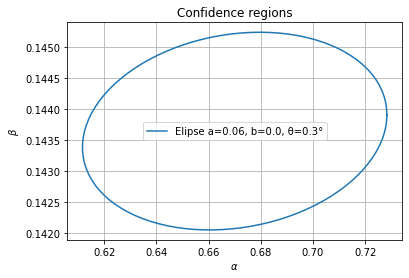

In [ ]:
#alpha = h
#beta = wm
A = 2.3
alpha = 2
beta = 3
# A = 6.18 2 sigma
#A = 11.8  3 sigma
a = A * np.sqrt((0.5 *(C_final[alpha,alpha] + C_final[beta,beta])) + np.sqrt((0.25*((C_final[alpha,alpha] - C_final[beta,beta])**2)) + (C_final[alpha, beta]**2)))
b = A * np.sqrt((0.5 *(C_final[alpha,alpha] + C_final[beta,beta])) - np.sqrt((0.25*((C_final[alpha,alpha] - C_final[beta,beta])**2)) + (C_final[alpha, beta]**2)))
phi = np.radians(0.5 * np.arctan((2* C_final[alpha, beta]) / (C_final[alpha,alpha] - C_final[beta,beta])))

print('phi=', phi)
print('a=', a)
print('b=', b)

plot_ellipse(a, b, phi, center_alpha= h, center_beta= wm)
